In [69]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML
from trend_following import (jupyter_interactive_mode, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             sharpe_ratio, create_trend_strategy, get_close_prices)

%matplotlib inline

In [70]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [3]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

File data found...reading ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data


In [4]:
def calculate_ts_momentum(df, close_px_col, lookback_period, period_name, returns_type='arithmetic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_log_returns'].rolling(window=lookback_period).sum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_pct_returns'].rolling(window=lookback_period).sum()
    
    return df

## THIS IS NON-COMPOUNDED RETURNS
def calculate_cumulative_returns(df, close_px_col, returns_type='logarithmic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_log_cum_returns'] = df[f'{close_px_col}_log_returns'].cumsum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_pct_cum_returns'] = df[f'{close_px_col}_pct_returns'].cumsum()
    
    return df

In [5]:
def get_long_and_short_term_momentum(df, close_px_col, returns_type, weekend_trading=False):
    
    if weekend_trading:
        trading_lookback_periods = [10, 21, 63, 126, 252]
    else:
        trading_lookback_periods = [10, 30, 90, 180, 365]
        
    lookback_period_names = ['10_day', '1_month', '3_month', '6_month', '12_month']
    
    c = 0
    for lookback in trading_lookback_periods:
        df = calculate_ts_momentum(df, close_px_col, lookback_period=lookback, period_name=lookback_period_names[c], returns_type=returns_type)
        c+=1
    
    return df

In [6]:
def generate_momentum_signal(df, ticker, momentum_type, threshold):
    
    df[f'{ticker}_{momentum_type}_signal'] = np.where(df[f'{ticker}_{momentum_type}'] > threshold, 1,
                                             np.where(df[f'{ticker}_{momentum_type}'] < -threshold, -1, np.nan))
    df[f'{ticker}_{momentum_type}_signal'] = df[f'{ticker}_{momentum_type}_signal'].shift(1)
    
    df[f'{ticker}_daily_returns'] = df[f'{ticker}'].pct_change()
    
    df[f'{ticker}_{momentum_type}_strategy_returns'] = df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns']
    
    # Calculate cumulative returns
    df[f'{ticker}_{momentum_type}_cum_strategy_returns'] = (1 + df[f'{ticker}_{momentum_type}_strategy_returns']).cumprod() - 1
    df[f'{ticker}_{momentum_type}_cum_buy_and_hold_returns'] = (1 + df[f'{ticker}_daily_returns']).cumprod() - 1
    
    return df

In [7]:
def calculate_drawdown(df, strategy_daily_return_col):
    
    df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1
    df[f'strategy_cumulative_return_cum_max'] = df['strategy_cumulative_return'].cummax()
    df[f'strategy_cumulative_return_drawdown'] = df['strategy_cumulative_return'] - df[f'strategy_cumulative_return_cum_max']
    df[f'strategy_cumulative_return_drawdown_pct'] = df[f'strategy_cumulative_return_drawdown'] / df[f'strategy_cumulative_return_cum_max']
    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    
    # Calculate maximum drawdown
    max_drawdown = df[f'strategy_cumulative_return_drawdown_pct'].min()
    
    # Calculate maximum drawdown duration
    df['End'] = df.index
    df['Start'] = df[f'strategy_cumulative_return_cum_max'].ne(df[f'strategy_cumulative_return_cum_max'].shift(1)).cumsum()
    df[f'strategy_cumulative_return_DDDuration'] = df.groupby('Start')['End'].transform(lambda x: x.max() - x.min())
    max_drawdown_duration = df[f'strategy_cumulative_return_DDDuration'].max()

    # Drop NaN values for better display
#     df = df.dropna(inplace=True)
    return df, max_drawdown, max_drawdown_duration

In [77]:
data.head(100)

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_pct_returns,BTC-USD_10_mavg,BTC-USD_10_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_strategy_returns,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade
Date,,,,,,,,,,,,,,,,,,,,,,,
2015-04-11,NaN,NaN,236.552002,NaN,NaN,NaN,0.002033,245.900266,-0.459751,253.183493,-0.610655,-7.283227,0.020119,0.025576,0.029575,0.033508,0.049346,-1.0,-0.002033,1,0.002033,NaN,236.552002
2015-04-12,NaN,NaN,236.153000,NaN,NaN,NaN,-0.001687,244.128036,-0.682560,252.795855,-0.618486,-8.667819,0.017750,0.025592,0.029241,0.033505,0.049339,-1.0,0.001687,-1,0.001687,NaN,236.153000
2015-04-13,NaN,NaN,224.587006,NaN,NaN,NaN,-0.048977,240.575121,-1.099095,252.155676,-0.510768,-11.580555,0.021563,0.021596,0.030270,0.034111,0.046740,-1.0,0.048977,-1,0.048977,-2.0,224.587006
2015-04-14,NaN,NaN,219.158997,NaN,NaN,NaN,-0.024169,236.681280,-1.527223,251.409000,-0.417694,-14.727720,0.021572,0.021979,0.030102,0.033307,0.040989,-1.0,0.024169,-1,0.024169,0.0,0.000000
2015-04-15,NaN,NaN,223.832993,NaN,NaN,NaN,0.021327,234.345228,-1.918001,250.786747,-0.384996,-16.441519,0.020362,0.022558,0.030302,0.031104,0.036555,-1.0,-0.021327,-1,-0.021327,0.0,0.000000
2015-04-16,NaN,NaN,228.572998,NaN,NaN,NaN,0.021177,233.295732,-2.058710,250.286875,-0.384571,-16.991143,0.023202,0.023299,0.030712,0.029137,0.036599,-1.0,-0.021177,-1,-0.021177,0.0,0.000000
2015-04-17,NaN,NaN,222.882004,NaN,NaN,NaN,-0.024898,231.402327,-2.235272,249.671848,-0.399199,-18.269522,0.023605,0.022854,0.025175,0.029309,0.036407,-1.0,0.024898,-1,0.024898,0.0,0.000000
2015-04-18,NaN,NaN,223.356003,NaN,NaN,NaN,0.002127,229.939359,-2.222786,249.082817,-0.396729,-19.143459,0.022890,0.021466,0.024853,0.028786,0.035955,-1.0,-0.002127,-1,-0.002127,0.0,0.000000
2015-04-19,NaN,NaN,222.600006,NaN,NaN,NaN,-0.003385,228.604931,-2.201843,248.491575,-0.404627,-19.886644,0.022936,0.020729,0.024809,0.028537,0.035894,-1.0,0.003385,-1,0.003385,0.0,0.000000


In [8]:
def calculate_CAGR(df, strategy_daily_return_col, annual_trading_days=252):
    
    # Calculate cumulative return
    df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1

    # Calculate the total cumulative return at the end of the period
    total_cumulative_return = df['strategy_cumulative_return'].iloc[-1]

    # Calculate the number of periods (days)
    num_periods = len(df)

    # Convert the number of periods to years (assuming daily data, 252 trading days per year)
    trading_days_per_year = annual_trading_days
    num_years = num_periods / trading_days_per_year

    # Calculate CAGR
    annualized_return = (1 + total_cumulative_return) ** (1 / num_years) - 1

    # Convert the annualized return to a percentage
#     annualized_return_percentage = annualized_return * 100
    
    return annualized_return

In [9]:
def calculate_hit_rate(df, strategy_daily_return_col):
    
    # Identify profitable trades (daily returns > 0)
    df['profitable_trade'] = df[strategy_daily_return_col] > 0

    # Calculate hit rate
    total_trades = df['profitable_trade'].count()
    profitable_trades = df['profitable_trade'].sum()
    hit_rate = profitable_trades / total_trades
    
    return hit_rate

In [10]:
from scipy import stats
def calculate_t_stat(df, strategy_daily_return_col):
    
    mean_return = df[strategy_daily_return_col].mean()
    std_dev_return = df[strategy_daily_return_col].std()
    num_days = len(df[strategy_daily_return_col])
    t_stat = mean_return/(std_dev_return/np.sqrt(num_days))
    p_value = stats.t.sf(np.abs(t_stat), df=num_days-1) * 2
    
    return t_stat, p_value

In [11]:
def calculate_risk_and_performance_metrics(df, strategy_daily_return_col, annual_rf=0.05, annual_trading_days=252):
    
    # Calculate CAGR
    annualized_return = calculate_CAGR(df, strategy_daily_return_col=strategy_daily_return_col, annual_trading_days=annual_trading_days)
    
    # Calculate Annualized Sharpe Ratio
    annualized_sharpe_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, annual_trading_days=annual_trading_days, annual_rf=annual_rf)
    
    # Calculate Annualized Standard Deviation
    annualized_std_dev = df[strategy_daily_return_col].std() * np.sqrt(annual_trading_days)
    
    # Calculate Max Drawdown
    df, max_drawdown, max_drawdown_duration = calculate_drawdown(df, strategy_daily_return_col=strategy_daily_return_col)
    
    # Calculate Hit Rate
    hit_rate = calculate_hit_rate(df, strategy_daily_return_col=strategy_daily_return_col)
    
    # Calculate T-Stat and P-Value
    t_stat, p_value = calculate_t_stat(df, strategy_daily_return_col=strategy_daily_return_col)
    
    performance_metrics = {'annualized_return': annualized_return,
                           'annualized_sharpe_ratio': annualized_sharpe_ratio,
                           'annualized_std_dev': annualized_std_dev,
                           'max_drawdown': max_drawdown,
                           'max_drawdown_duration': max_drawdown_duration,
                           'hit_rate': hit_rate,
                           't_statistic': t_stat,
                           'p_value': p_value}
    
    return performance_metrics

In [12]:
ticker = '^VIX'
data_VIX = get_close_prices(start_date, end_date, ticker)

File data found...reading ['^VIX'] data


In [13]:
data_VIX.head()

,^VIX
Date,
2014-09-17,12.65
2014-09-18,12.03
2014-09-19,12.11
2014-09-22,13.69
2014-09-23,14.93


In [14]:
ticker_list = ['BTC-USD','ETH-USD','XRP-USD','SOL-USD','BCH-USD']
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns')
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

BTC-USD
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
ETH-USD
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
XRP-USD
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
SOL-USD
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...read

In [15]:
df_final

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value
BTC-USD_10_day_momentum_strategy_returns,-0.403425,-0.215590,0.870511,-76.174063,2825 days,0.478659,-0.182011,0.855687
BTC-USD_1_month_momentum_strategy_returns,0.452979,0.809527,0.737066,-3.573054,1712 days,0.527675,1.572948,0.116120
BTC-USD_3_month_momentum_strategy_returns,0.458818,0.829178,0.656282,-1.302402,865 days,0.523810,2.404699,0.016287
BTC-USD_6_month_momentum_strategy_returns,0.498839,0.886621,0.614538,-0.988381,1167 days,0.526684,2.909543,0.003655
BTC-USD_12_month_momentum_strategy_returns,0.511785,0.910909,0.589322,-4.633850,1604 days,0.528963,3.361093,0.000786
BTC-USD_12_month_minus_1_month_momentum_strategy_returns,0.539657,0.939716,0.593020,-5.015751,1788 days,0.531853,3.374263,0.000750
ETH-USD_10_day_momentum_strategy_returns,-0.016659,0.423126,0.973632,-1.035454,1115 days,0.503226,0.524885,0.600039
ETH-USD_1_month_momentum_strategy_returns,0.105451,0.491413,0.870242,-1.123259,1154 days,0.494935,0.906588,0.364941
ETH-USD_3_month_momentum_strategy_returns,-0.074544,0.247909,0.788544,-1.140618,1787 days,0.512879,0.709009,0.478444
ETH-USD_6_month_momentum_strategy_returns,0.566609,0.915288,0.729784,-1.459932,757 days,0.534557,2.501706,0.012457


In [16]:
data.head()

,BCH-USD,BCH-USD_log_returns,BCH-USD_10_day_momentum,BCH-USD_1_month_momentum,BCH-USD_3_month_momentum,BCH-USD_6_month_momentum,BCH-USD_12_month_momentum,BCH-USD_12_month_minus_1_month_momentum,BCH-USD_12_month_minus_1_month_momentum_signal,BCH-USD_daily_returns,BCH-USD_12_month_minus_1_month_momentum_strategy_returns,BCH-USD_12_month_minus_1_month_momentum_cum_strategy_returns,BCH-USD_12_month_minus_1_month_momentum_cum_buy_and_hold_returns,strategy_cumulative_return,strategy_cumulative_return_cum_max,strategy_cumulative_return_drawdown,strategy_cumulative_return_drawdown_pct,End,Start,strategy_cumulative_return_DDDuration,profitable_trade
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-21,789.486023,0.028042,0.109673,0.053032,-0.406082,-0.184847,-0.529378,-0.582410,-1.0,0.028439,-0.028439,-0.028439,0.206606,-0.028439,-0.028439,0.000000,-0.000000,2018-07-21,1,0 days,False
2018-07-22,788.666016,-0.001039,0.144207,0.064470,-0.493426,-0.173530,-0.565896,-0.630366,-1.0,-0.001039,0.001039,-0.027429,0.205353,-0.027429,-0.027429,0.000000,-0.000000,2018-07-22,2,0 days,True
2018-07-23,784.385986,-0.005442,0.118707,0.010523,-0.452823,-0.237515,-0.545910,-0.556433,-1.0,-0.005427,0.005427,-0.022151,0.198812,-0.022151,-0.022151,0.000000,-0.000000,2018-07-23,3,7 days,True
2018-07-24,869.466980,0.102979,0.211021,0.137267,-0.272533,-0.197313,-0.381668,-0.518934,-1.0,0.108468,-0.108468,-0.128217,0.328845,-0.128217,-0.022151,-0.106066,4.788219,2018-07-24,3,7 days,False
2018-07-25,831.455017,-0.044703,0.139804,0.086712,-0.190172,-0.217481,-0.377180,-0.463892,-1.0,-0.043719,0.043719,-0.090104,0.270749,-0.090104,-0.022151,-0.067952,3.067637,2018-07-25,3,7 days,True


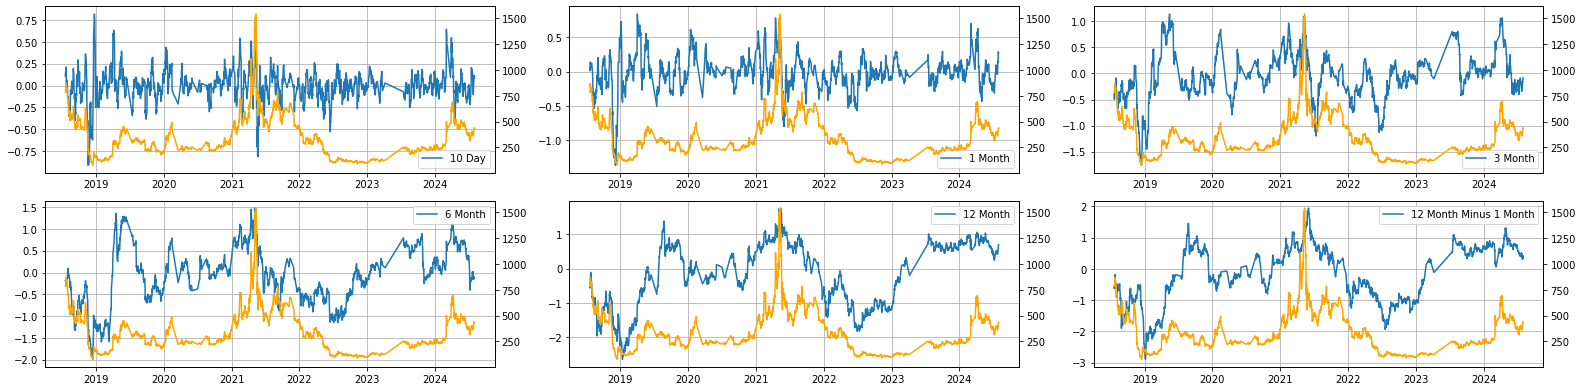

In [17]:
ticker = 'BCH-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_1 = momentum_ax_1.twinx()
_ = momentum_ax_1.plot(data.index, data[f'{ticker}_10_day_momentum'], label='10 Day')
_ = momentum_twin_ax_1.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_2 = momentum_ax_2.twinx()
_ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
_ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_3 = momentum_ax_3.twinx()
_ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
_ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = momentum_ax_1.grid()
_ = momentum_ax_1.legend()
_ = momentum_ax_2.grid()
_ = momentum_ax_2.legend()
_ = momentum_ax_3.grid()
_ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()

plt.tight_layout()

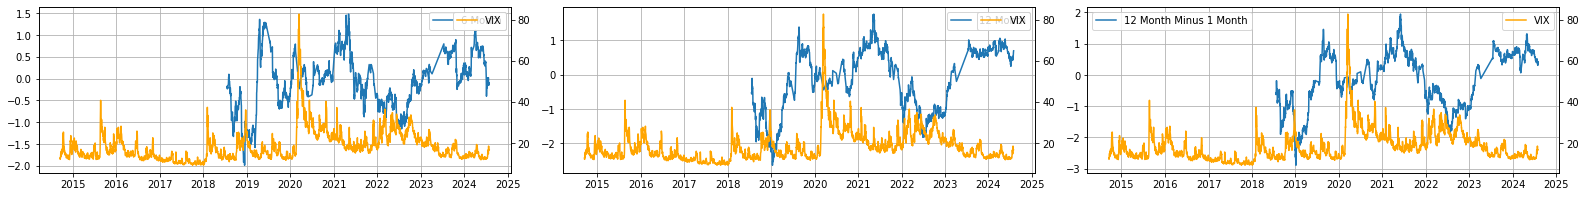

In [18]:
ticker = 'BCH-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
# momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
# momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

# _ = momentum_ax_1.grid()
# _ = momentum_ax_1.legend()
# _ = momentum_ax_2.grid()
# _ = momentum_ax_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_twin_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_twin_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()
_ = momentum_twin_ax_6.legend()

plt.tight_layout()

In [ ]:
data['BTC-USD'].corr(data_VIX['^VIX'])

In [ ]:
def generate_trend_signal(df, mavg_slope_col_list, ticker='BTC-USD'):
    
    def slope_signal(row):
        if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
            return 'downtrend'
        elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
            return 'uptrend'
        
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)

    return df

In [ ]:
for end in np.linspace(200, 600, 3):
    print(end)

In [ ]:
for end in np.arange(200, 1000, 50):
    for start in np.arange(10, end, 10):
        for stepsizes in np.arange(1,10,1):
            print(start, end, end/start*stepsizes)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

In [ ]:
df_tsla = get_close_prices(start_date, end_date, ticker='TSLA')

In [ ]:
df_tsla.head()

In [ ]:
len(ticker)

In [ ]:
data.head(10)

In [ ]:
ticker = ['SPY']
data_SPY = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data_SPY.head(10)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 21)
ticker = ['PL=F']
data = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
# def create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, vol_range_list=[10, 20, 30, 60, 90]):
    
#     for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#         df[f'{ticker}_{int(window)}_mavg'] = df[f'{ticker}'].rolling(int(window)).mean()
#         df[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(df, column=f'{ticker}_{int(window)}_mavg', periods=window)

#     df[f'{ticker}_ribbon_thickness'] = df[f'{ticker}_{int(mavg_start)}_mavg'] - df[f'{ticker}_{int(mavg_end)}_mavg']
#     df[f'{ticker}_ribbon_thickness_diff'] = df[f'{ticker}_ribbon_thickness'].diff()
#     df = get_returns_volatility(df, vol_range_list=vol_range_list, close_px_col=ticker)

#     ## Ticker Trend Signal and Trade
#     mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
#     mavg_slope_col_list = [f'{ticker}_{int(mavg)}_mavg_slope' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
#     df[f'{ticker}_trend_signal'] = df[mavg_col_list].apply(trend_signal, axis=1)
#     df[f'{ticker}_trend_signal_diff'] = df[f'{ticker}_trend_signal'].diff().shift(1)
#     df[f'{ticker}_trend_trade'] = np.where(df[f'{ticker}_trend_signal_diff'] != 0, df[f'{ticker}'], np.nan)
#     df[f'{ticker}_trend_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_signal_diff']
    
#     ## Ticker Trend Slope Signal and Trade
#     df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)
#     df[f'{ticker}_trend_slope_signal_diff'] = df[f'{ticker}_trend_slope_signal'].diff().shift(1)
#     df[f'{ticker}_trend_slope_trade'] = np.where(df[f'{ticker}_trend_slope_signal_diff'] != 0, df[f'{ticker}'], np.nan)
#     df[f'{ticker}_trend_slope_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_slope_signal_diff']
    
#     ## Drop all null values
#     df = df[df[f'{ticker}_{mavg_end}_mavg_slope'].notnull()]
    
#     ## Calculate P&L
#     df[f'{ticker}_mavg_trend_PnL'] = df[f'{ticker}_trend_signal_diff'] * df[f'{ticker}_trend_trade'] * -1
#     df[f'{ticker}_mavg_slope_PnL'] = df[f'{ticker}_trend_slope_signal_diff'] * df[f'{ticker}_trend_slope_trade'] * -1
    
#     ## Calculate Cumulative P&L
#     df[f'{ticker}_mavg_trend_PnL_cum'] = df[f'{ticker}_mavg_trend_PnL'].cumsum()
#     df[f'{ticker}_mavg_slope_PnL_cum'] = df[f'{ticker}_mavg_slope_PnL'].cumsum()
   
#     return df

In [19]:
def get_mavg_windows():
    mavg_list = []
    _mavg = []
    mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
    mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    for i in np.arange(0,10,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [23]:
def get_mavg_strategy_performance(start_date, end_date, ticker_list):
    if isinstance(ticker_list, str):
        ticker_list = [ticker_list]
    mavg_list = get_mavg_windows()
    performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown',
                           'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
    final_perf_stats = []
    
    for ticker in ticker_list:
        print(ticker)
        df_temp_results = pd.DataFrame(columns=performance_columns)
#         _results = []
        for mavg_start, mavg_end, mavg_stepsize in mavg_list:
            print(mavg_start, mavg_end, mavg_stepsize)
            df = get_close_prices(start_date, end_date, ticker)
            df = create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')
#             df = df.dropna()
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_strategy_returns'] != 0).any()):
                trend_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
                trend_slope_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_slope_metrics
#             _sharpe = sharpe_ratio(df, return_col=f'{ticker}_trend_strategy_returns', trade_col=f'{ticker}_trend_trade')
#             _pnl = df[f'{ticker}_mavg_trend_PnL'].sum()
#             _results.append([ticker, mavg_start, mavg_end, mavg_stepsize, round(_sharpe, 2), round(_pnl, 2)])
        final_perf_stats.append(df_temp_results)
#     flattened_list = [item for sublist in all_results for item in sublist]
    
#     columns = ['ticker','mavg_start','mavg_end','mavg_stepsize','sharpe_ratio','pnl']
#     df_results = pd.DataFrame(flattened_list, columns=columns)
    df_results = pd.concat(final_perf_stats, axis=0)
    
    return df_results

In [26]:
ticker_list = ['ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
df_results = get_mavg_strategy_performance(start_date, end_date, ticker_list)

ETH-USD
10 100 2
File data found...reading ['ETH-USD'] data
10 100 4
File data found...reading ['ETH-USD'] data
10 100 10
File data found...reading ['ETH-USD'] data
20 200 2
File data found...reading ['ETH-USD'] data
20 200 4
File data found...reading ['ETH-USD'] data
20 200 10
File data found...reading ['ETH-USD'] data
20 200 19
File data found...reading ['ETH-USD'] data
30 300 2
File data found...reading ['ETH-USD'] data
30 300 4
File data found...reading ['ETH-USD'] data
30 300 10
File data found...reading ['ETH-USD'] data
30 300 28
File data found...reading ['ETH-USD'] data
40 400 2
File data found...reading ['ETH-USD'] data
40 400 4
File data found...reading ['ETH-USD'] data
40 400 10
File data found...reading ['ETH-USD'] data
40 400 37
File data found...reading ['ETH-USD'] data
50 500 2
File data found...reading ['ETH-USD'] data
50 500 4
File data found...reading ['ETH-USD'] data
50 500 10
File data found...reading ['ETH-USD'] data
50 500 46
File data found...reading ['ETH-USD'] 

100 1000 91
File data found...reading ['BNB-USD'] data
BTC-USD
10 100 2
File data found...reading ['BTC-USD'] data
10 100 4
File data found...reading ['BTC-USD'] data
10 100 10
File data found...reading ['BTC-USD'] data
20 200 2
File data found...reading ['BTC-USD'] data
20 200 4
File data found...reading ['BTC-USD'] data
20 200 10
File data found...reading ['BTC-USD'] data
20 200 19
File data found...reading ['BTC-USD'] data
30 300 2
File data found...reading ['BTC-USD'] data
30 300 4
File data found...reading ['BTC-USD'] data
30 300 10
File data found...reading ['BTC-USD'] data
30 300 28
File data found...reading ['BTC-USD'] data
40 400 2
File data found...reading ['BTC-USD'] data
40 400 4
File data found...reading ['BTC-USD'] data
40 400 10
File data found...reading ['BTC-USD'] data
40 400 37
File data found...reading ['BTC-USD'] data
50 500 2
File data found...reading ['BTC-USD'] data
50 500 4
File data found...reading ['BTC-USD'] data
50 500 10
File data found...reading ['BTC-USD'

In [27]:
df_results

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value
ETH-USD_10-100-2_trend_strategy_returns,0.155270,0.484760,0.709208,-1.220520,1601 days,0.485350,1.692239,9.073281e-02
ETH-USD_10-100-2_trend_slope_strategy_returns,18.039396,4.611618,0.680625,-1.438650,38 days,0.609766,14.316869,1.216203e-44
ETH-USD_10-100-4_trend_strategy_returns,0.148232,0.439543,0.581363,-1.125228,1298 days,0.294692,1.600262,1.096746e-01
ETH-USD_10-100-4_trend_slope_strategy_returns,3.023609,3.396456,0.420916,-0.369262,94 days,0.165605,10.737343,2.731645e-26
ETH-USD_10-100-10_trend_strategy_returns,0.171884,0.467755,0.537665,-1.125228,1298 days,0.236518,1.707358,8.788749e-02
ETH-USD_10-100-10_trend_slope_strategy_returns,0.181945,0.719198,0.184820,-0.124337,662 days,0.010616,3.005676,2.677904e-03
ETH-USD_20-200-2_trend_strategy_returns,0.037972,0.332494,0.704358,-14.575392,1287 days,0.488248,1.201849,2.295483e-01
ETH-USD_20-200-2_trend_slope_strategy_returns,8.437819,3.545967,0.686970,-1.883612,95 days,0.585809,10.819846,1.235878e-26
ETH-USD_20-200-4_trend_strategy_returns,0.157099,0.453977,0.559525,-2.708998,1298 days,0.313525,1.618895,1.056097e-01
ETH-USD_20-200-4_trend_slope_strategy_returns,1.639859,2.458157,0.407443,-0.305741,152 days,0.156541,7.711551,1.851339e-14


In [22]:
df_results

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value
ETH-USD_10-100-2_trend_strategy_returns,0.170940,0.516127,0.709083,-5.701740,773 days,0.519525,1.788543,0.073817
ETH-USD_10-100-2_trend_slope_strategy_returns,1.096301,1.328531,0.706829,-1.206091,478 days,0.517402,4.273259,0.000020
ETH-USD_10-100-4_trend_strategy_returns,0.276684,0.628779,0.581874,-1.694394,1176 days,0.370119,2.178993,0.029431
ETH-USD_10-100-4_trend_slope_strategy_returns,0.279789,0.705629,0.384508,-0.776818,1029 days,0.147284,2.545586,0.010973
ETH-USD_10-100-10_trend_strategy_returns,0.288134,0.651806,0.528144,-1.199799,1176 days,0.298812,2.275486,0.022966
ETH-USD_10-100-10_trend_slope_strategy_returns,0.024264,-0.015948,0.209070,-1.442532,1176 days,0.034380,0.664863,0.506203
ETH-USD_20-200-2_trend_strategy_returns,0.183205,0.529205,0.704702,-1.956035,875 days,0.526596,1.790584,0.073494
ETH-USD_20-200-2_trend_slope_strategy_returns,0.470734,0.829287,0.704075,-1.956035,717 days,0.515957,2.688629,0.007227
ETH-USD_20-200-4_trend_strategy_returns,0.047112,0.316965,0.626974,-1.956035,870 days,0.382979,1.181237,0.237633
ETH-USD_20-200-4_trend_slope_strategy_returns,0.237008,0.593279,0.436047,-3.592855,1176 days,0.176862,2.109943,0.034973


In [ ]:
ticker = 'BTC-USD'
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
df_temp_results = pd.DataFrame(columns=performance_columns)
df_test = get_close_prices(start_date, end_date, ticker)
df_test = create_trend_strategy(df_test, ticker, mavg_start, mavg_end, mavg_stepsize)
# df_test['BTC-USD_trend_signal_test'] = df_test['BTC-USD_trend_signal'].shift(1)
# df_test['BTC-USD_trend_strategy_returns_test'] = df_test['BTC-USD_trend_signal_test'] * df_test['BTC-USD_pct_returns']
# df_test = df_test.dropna()
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_strategy_returns'] != 0).any()):
    trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
    df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
    trend_slope_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
                
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_metrics

In [ ]:
df_test.shape

In [ ]:
df_temp_results

In [ ]:
calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns_test')

In [ ]:
df_test[['BTC-USD','BTC-USD_pct_returns','BTC-USD_trend_slope_signal','BTC-USD_trend_strategy_returns']].head(1000)

In [ ]:
df_test.tail(200)

In [ ]:
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    print(window)

In [ ]:
df_test#.shape

In [ ]:
df_test.head()

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
df_mavg_results = get_mavg_strategy_performance(start_date, end_date, ticker_list)

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns')
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

In [ ]:
mavg_list = get_mavg_windows()
mavg_list

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
df_results = get_strategy_performance(start_date, end_date, ticker)

In [ ]:
df_test.head()

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

mavg_cond = (df_results.mavg_start == 10) & (df_results.mavg_end == 100) & (df_results.mavg_stepsize == 4)
_ = sharpe_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['sharpe_ratio'])
_ = sharpe_ax.grid()
_ = pnl_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['pnl'])
_ = pnl_ax.grid()

plt.tight_layout()

In [ ]:
df_results[mavg_cond]

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['PL=F','ES=F']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ES=F', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ES=F_trend_strategy_returns', trade_col='ES=F_trend_trade')
    _pnl = data[f'ES=F_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
ticker = ['PL=F','ES=F']
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
# data = create_trend_stra.tegy(data, ticker='PL=F', mavg_start=10, mavg_end=100, mavg_stepsize=4)

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
pl_prices_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
es_prices_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

_ = pl_prices_ax.plot(data.index, data['PL=F'])
_ = es_prices_ax.plot(data.index, data['ES=F'])

plt.tight_layout()

In [ ]:
mavg_end

In [ ]:
data.tail(500)

In [ ]:
ticker = 'ES=F'
moving_avg_type='simple'
for window in np.linspace(10, 100, 4):
    if moving_avg_type == 'simple':
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].rolling(int(window)).mean()
    else:
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].ewm(span=window).mean()
    data[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(data, column=f'{ticker}_{int(window)}_mavg',
                                                               periods=window)

In [ ]:
data.tail(500)

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
data = load_financial_data(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
results_SPY = []
ticker = ['SPY']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data[['Adj Close']].rename(columns={'Adj Close': 'SPY'})
    data = create_trend_strategy(data, ticker='SPY', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='SPY_trend_strategy_returns', trade_col='SPY_trend_trade')
    _pnl = data[f'SPY_mavg_trend_PnL'].sum()
    results_SPY.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_SPY

In [62]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2

In [45]:
data.head()

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_pct_returns,BTC-USD_10_mavg,BTC-USD_10_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_strategy_returns,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-12-27,NaN,NaN,315.863007,NaN,NaN,NaN,-0.036780,-0.006442,0.000933,-0.003040,0.000689,-0.003402,0.030041,0.026322,0.022819,0.033189,0.032265,1.0,-0.036780,1,-0.036780,NaN,315.863007
2014-12-28,NaN,NaN,317.239014,NaN,NaN,NaN,0.004356,-0.004479,0.001319,-0.002871,0.000680,-0.001607,0.028696,0.025670,0.022467,0.032245,0.032269,-1.0,-0.004356,1,0.004356,NaN,317.239014
2014-12-29,NaN,NaN,312.670013,NaN,NaN,NaN,-0.014402,-0.006283,0.000441,-0.003133,0.000315,-0.003150,0.028330,0.025295,0.022518,0.032061,0.032117,-1.0,0.014402,1,-0.014402,0.0,0.000000
2014-12-30,NaN,NaN,310.737000,NaN,NaN,NaN,-0.006182,-0.006265,-0.000445,-0.003202,0.000289,-0.003063,0.024720,0.025164,0.022391,0.031970,0.032112,-1.0,0.006182,-1,0.006182,0.0,0.000000
2014-12-31,NaN,NaN,320.192993,NaN,NaN,NaN,0.030431,0.000407,0.000692,-0.002443,0.000212,0.002850,0.025796,0.026143,0.023321,0.031863,0.032216,-1.0,-0.030431,1,0.030431,-2.0,320.192993


In [71]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['PL=F','ES=F']
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 31)
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price')

File not found...downloading the ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data
[*********************100%***********************]  6 of 6 completed


In [72]:
sharpe_ratio(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns')

1.3342050142255781

In [ ]:
data['BTC-USD_mavg_trend_PnL'].sum()

In [ ]:
data.head()

In [ ]:
data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [ ]:
sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')

In [ ]:
data[data['ETH-USD_trend_trade'].notnull()]

In [ ]:
mavg_start_SPY = 50
mavg_end_SPY = 200
mavg_stepsize_SPY = 2

In [ ]:
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    print(window)
    data_SPY[f'SPY_{window}_mavg'] = data_SPY['SPY'].rolling(int(window)).mean()
#     data_SPY[f'SPY_{window}_mavg_slope'] = (data_SPY[f'SPY_10.0_mavg'] - data_SPY[f'SPY_10.0_mavg'].shift(int(window)))/window
    data_SPY[f'SPY_{window}_mavg_slope'] = calculate_slope(data_SPY, column=f'SPY_{window}_mavg', periods=window)
    
data_SPY['SPY_ribbon_thickness'] = data_SPY[f'SPY_{float(mavg_start_SPY)}_mavg'] - data_SPY[f'SPY_{float(mavg_end_SPY)}_mavg']
data_SPY = get_returns_volatility(data_SPY, vol_range_list=[10, 20, 30, 60, 90], close_px_col='SPY')

## SPY Trend Signal and Trade
SPY_mavg_col_list = [f'SPY_{mavg}_mavg' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
SPY_mavg_slope_col_list = [f'SPY_{mavg}_mavg_slope' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
data_SPY['SPY_trend_signal'] = data_SPY[SPY_mavg_col_list].apply(trend_signal, axis=1)
data_SPY['SPY_trend_signal_diff'] = data_SPY['SPY_trend_signal'].diff().shift(1)
data_SPY['SPY_trend_trade'] = np.where(data_SPY['SPY_trend_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_slope_signal'] = data_SPY[SPY_mavg_slope_col_list].apply(slope_signal, axis=1)
data_SPY['SPY_trend_slope_signal_diff'] = data_SPY['SPY_trend_slope_signal'].diff().shift(1)
data_SPY['SPY_trend_slope_trade'] = np.where(data_SPY['SPY_trend_slope_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_signal_diff']
data_SPY['SPY_trend_slope_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_slope_signal_diff']
# data_SPY['SPY_trend_trade'] = np.where((np.abs(data_SPY['SPY_ribbon_thickness']) > 2000) &
#                                    (data_SPY['SPY_trend_signal_diff'] != 0), data_SPY['SPY_trend_signal_diff'], np.nan)

In [ ]:
data.shape

In [ ]:
data_SPY.shape

In [ ]:
# data = data.dropna()
# data = data[data.index.get_level_values('Date') >= '2018-12-14']
data_SPY = data_SPY[data_SPY.index.get_level_values('Date') >= '2019-06-14']

In [ ]:
data['BTC_mavg_slope_PnL'] = data['BTC_trend_slope_signal_diff'] * data['BTC_trend_slope_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_slope_signal')
BTC_cols.append('BTC_trend_slope_signal_diff')
BTC_cols.append('BTC_mavg_slope_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_slope_strategy_returns')
cond = (data['BTC_trend_slope_signal_diff'] != 0)
data[cond][BTC_cols]

In [ ]:
data['BTC_mavg_trend_PnL'] = data['BTC_trend_signal_diff'] * data['BTC_trend_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_signal')
BTC_cols.append('BTC_trend_signal_diff')
BTC_cols.append('BTC_mavg_trend_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_strategy_returns')
cond = (data['BTC_trend_trade'].notnull())
data[cond][BTC_cols]

In [ ]:
data['ETH_mavg_slope_PnL'] = data['ETH_trend_slope_signal_diff'] * data['ETH_trend_slope_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_slope_signal')
ETH_cols.append('ETH_trend_slope_signal_diff')
ETH_cols.append('ETH_mavg_slope_PnL')
cond = (data['ETH_trend_slope_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data['ETH_mavg_trend_PnL'] = data['ETH_trend_signal_diff'] * data['ETH_trend_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_signal')
ETH_cols.append('ETH_trend_signal_diff')
ETH_cols.append('ETH_mavg_trend_PnL')
cond = (data['ETH_trend_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data_SPY['SPY_mavg_trend_PnL'] = data_SPY['SPY_trend_signal_diff'] * data_SPY['SPY_trend_trade'] * -1
SPY_cols = [col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-5:] == 'slope')]
SPY_cols.append('SPY_trend_signal')
SPY_cols.append('SPY_trend_signal_diff')
SPY_cols.append('SPY_mavg_trend_PnL')
cond = (data_SPY['SPY_trend_trade'].notnull())
data_SPY[cond][SPY_cols]

In [ ]:
# Calculate the mean and standard deviation of the strategy returns
# mean_strategy_return = data['strategy_return'].mean()
# std_strategy_return = data['strategy_return'].std()

# Calculate annualized Sharpe Ratio (assuming 252 trading days in a year)
N = 255 #255 trading days in a year
rf =0.05 #1% risk free rate
cond = (data['BTC_trend_trade'].notnull())
sharpes = sharpe_ratio(data[cond]['BTC_trend_strategy_returns'], N, rf)

In [ ]:
data.head()

In [ ]:
print(f"BTC-USD_mavg_trend_PnL: {data['BTC-USD_mavg_trend_PnL'].sum()}")
cond = (data['BTC-USD_trend_signal_diff'] != 0)
print(f"BTC-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')}")
print(f"BTC-USD_mavg_slope_PnL: {data['BTC-USD_mavg_slope_PnL'].sum()}")
cond = (data['BTC-USD_trend_slope_signal_diff'] != 0)
print(f"BTC-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_slope_strategy_returns', trade_col='BTC-USD_trend_slope_trade')}")

In [ ]:
print(f"ETH-USD_mavg_trend_PnL: {data['ETH-USD_mavg_trend_PnL'].sum()}")
cond = (data['ETH-USD_trend_signal_diff'] != 0)
print(f"ETH-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')}")
print(f"ETH-USD_mavg_slope_PnL: {data['ETH-USD_mavg_slope_PnL'].sum()}")
cond = (data['ETH-USD_trend_slope_signal_diff'] != 0)
print(f"ETH-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_slope_strategy_returns', trade_col='ETH-USD_trend_slope_trade')}")

In [ ]:
[col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-4:] == 'mavg')]

In [ ]:
data_SPY.loc[data_SPY.index >= '2020-03-01'][['SPY','SPY_50.0_mavg','SPY_200.0_mavg','SPY_trend_signal','SPY_trend_signal_diff','SPY_mavg_trend_PnL','SPY_ribbon_thickness']].head(500)

In [ ]:
data.loc[data.index >= '2022-05-01'][['BTC-USD','BTC_20.0_mavg','BTC_40.0_mavg','BTC_60.0_mavg','BTC_80.0_mavg','BTC_100.0_mavg','BTC_120.0_mavg','BTC_140.0_mavg',
                                      'BTC_160.0_mavg','BTC_180.0_mavg','BTC_200.0_mavg','BTC_trend_signal','BTC_trend_signal_diff','BTC_mavg_trend_PnL','BTC_ribbon_thickness']].head(500)

In [ ]:
data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl = data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl['BTC-USD_mavg_trend_PnL_cum'] = data_Pnl['BTC-USD_mavg_trend_PnL'].cumsum()

In [ ]:
data[data['BTC-USD_trend_trade'].notnull()].head(100)

In [ ]:
data['BTC-USD_ribbon_thickness_diff'] = data['BTC-USD_ribbon_thickness'].diff()

In [ ]:
data.index[3-1]

In [ ]:
data.head(500)

In [ ]:
for j in range(1, 4):
    print(j)

In [ ]:
data['BTC-USD_ribbon_thickness_signal'] = np.nan
data.loc[data.index[0:3], 'BTC-USD_ribbon_thickness_signal'] = 0
lookback_period = 3
for i in range(lookback_period, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] > data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 1
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] < data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = -1
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Buy'
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 0#data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal']

data['BTC-USD_ribbon_thickness_position'] = data['BTC-USD_ribbon_thickness_signal'].diff()
        
data['BTC-USD_ribbon_thickness_PnL'] = data['BTC-USD_ribbon_thickness_position'] * data['BTC-USD']
data['BTC-USD_ribbon_thickness_cum_PnL'] = data['BTC-USD_ribbon_thickness_PnL'].cumsum()

In [ ]:
trend_buy_signal = (data['BTC-USD_trend_signal'] == 1)
trend_sell_signal = (data['BTC-USD_trend_signal'] == -1)
ribbon_thickness_buy_signal = (data['BTC-USD_ribbon_thickness_signal'] == 1)
ribbon_thickness_sell_signal = (data['BTC-USD_ribbon_thickness_signal'] == -1)
data['BTC-USD_trend_ribbon_thickness_combo_signal'] = np.where(trend_buy_signal & ribbon_thickness_buy_signal, 1,
                                                              np.where(trend_sell_signal & ribbon_thickness_sell_signal, -1, 0))
data['BTC-USD_trend_ribbon_thickness_combo_position'] = data['BTC-USD_trend_ribbon_thickness_combo_signal'].diff()
data['BTC-USD_trend_ribbon_thickness_combo_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_position'] * data['BTC-USD']
data['BTC-USD_trend_ribbon_thickness_combo_cum_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_PnL'].cumsum()

In [ ]:
data['BTC-USD_trend_ribbon_thickness_combo_PnL'].sum()

In [ ]:
data[['BTC-USD','BTC-USD_ribbon_thickness','BTC-USD_ribbon_thickness_diff','BTC-USD_ribbon_thickness_signal','BTC-USD_trend_signal','BTC-USD_ribbon_thickness_position','BTC-USD_ribbon_thickness_PnL',
     'BTC-USD_ribbon_thickness_cum_PnL']].head(500)

In [ ]:
data['BTC-USD_ribbon_thickness_PnL'].sum()

In [ ]:
data['BTC-USD_ribbon_thickness_slope'] = calculate_slope(data, column='BTC-USD_ribbon_thickness', periods=50)
data['BTC-USD_ribbon_thickness_slope_diff'] = data['BTC-USD_ribbon_thickness_slope'].diff()
data['BTC-USD_ribbon_thickness_slope_position'] = np.nan
data.loc[data.index[0], 'BTC-USD_ribbon_thickness_slope_position'] = 'No Position'
for i in range(3, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] > 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Buy'
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] < 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Sell'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_slope_position'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Buy'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_position'] = data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position']
        
        

In [41]:
data.head(100)

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_pct_returns,BTC-USD_10_mavg,BTC-USD_10_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_strategy_returns,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-12-27,NaN,NaN,315.863007,NaN,NaN,NaN,-0.036780,-6.442091e-03,0.000933,-0.003040,0.000689,-0.003402,0.030041,0.026322,0.022819,0.033189,0.032265,1.0,-0.036780,1,-0.036780,NaN,315.863007
2014-12-28,NaN,NaN,317.239014,NaN,NaN,NaN,0.004356,-4.478739e-03,0.001319,-0.002871,0.000680,-0.001607,0.028696,0.025670,0.022467,0.032245,0.032269,-1.0,-0.004356,1,0.004356,NaN,317.239014
2014-12-29,NaN,NaN,312.670013,NaN,NaN,NaN,-0.014402,-6.283040e-03,0.000441,-0.003133,0.000315,-0.003150,0.028330,0.025295,0.022518,0.032061,0.032117,-1.0,0.014402,1,-0.014402,0.0,0.000000
2014-12-30,NaN,NaN,310.737000,NaN,NaN,NaN,-0.006182,-6.264720e-03,-0.000445,-0.003202,0.000289,-0.003063,0.024720,0.025164,0.022391,0.031970,0.032112,-1.0,0.006182,-1,0.006182,0.0,0.000000
2014-12-31,NaN,NaN,320.192993,NaN,NaN,NaN,0.030431,4.072035e-04,0.000692,-0.002443,0.000212,0.002850,0.025796,0.026143,0.023321,0.031863,0.032216,-1.0,-0.030431,1,0.030431,-2.0,320.192993
2015-01-01,NaN,NaN,314.248993,NaN,NaN,NaN,-0.018564,-3.042071e-03,-0.000397,-0.002806,0.000021,-0.000236,0.023282,0.026221,0.023349,0.031954,0.031984,1.0,-0.018564,-1,0.018564,2.0,314.248993
2015-01-02,NaN,NaN,315.032013,NaN,NaN,NaN,0.002492,-2.035927e-03,-0.000427,-0.002687,0.000058,0.000651,0.022992,0.026183,0.023316,0.031949,0.030699,-1.0,-0.002492,-1,-0.002492,-2.0,315.032013
2015-01-03,NaN,NaN,281.082001,NaN,NaN,NaN,-0.107767,-2.125973e-02,-0.001655,-0.005039,0.000060,-0.016221,0.039064,0.034547,0.029855,0.034810,0.032631,1.0,-0.107767,-1,0.107767,0.0,0.000000
2015-01-04,NaN,NaN,264.195007,NaN,NaN,NaN,-0.060079,-2.831770e-02,-0.002247,-0.006268,0.000055,-0.022050,0.041781,0.036265,0.030786,0.035383,0.033052,-1.0,0.060079,-1,0.060079,0.0,0.000000


In [75]:
np.abs(data['BTC-USD_trend_slope_signal_diff']).sum()

316.0

In [73]:
ticker = 'BTC-USD'
data[f'{ticker}_trend_slope_signal_diff'] = data[f'{ticker}_trend_slope_signal'].diff().shift(1)
data[f'{ticker}_trend_slope_trade'] = np.where(data[f'{ticker}_trend_slope_signal_diff'] != 0, data[f'{ticker}'], 0)

No handles with labels found to put in legend.


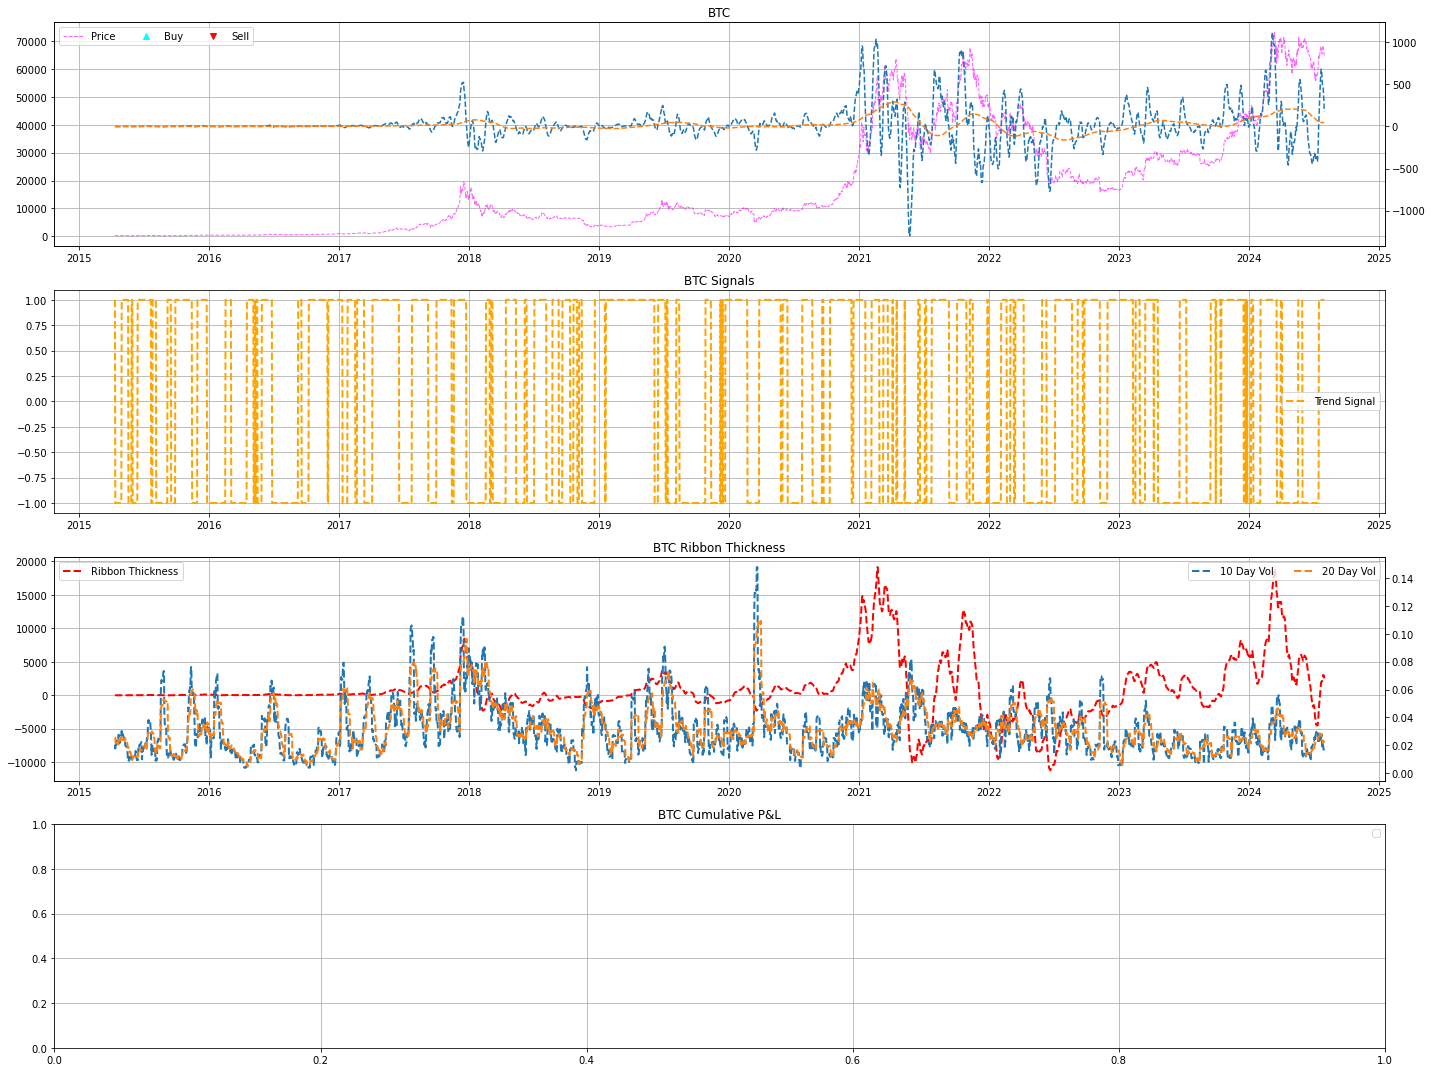

In [74]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
# _ = mavg_ax.plot(data.index, data['BTC-USD_pct_returns'], label='Returns', linestyle='--', color='red', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax2.plot(data.index, data[f'BTC-USD_{int(window)}_mavg_slope'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['BTC-USD_trend_slope_signal_diff'] == 1)
sell_cond = (data['BTC-USD_trend_slope_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# pnl_cond = (data['BTC-USD_trend_slope_trade'].notnull())
# _ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_slope_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

## data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness'])

In [ ]:
data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness_slope'])

In [ ]:
data.iloc[i-0]['BTC-USD_ribbon_thickness_diff']

In [ ]:
all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_diff'] > 0 for j in range(1,4))

In [ ]:
data.loc[data.index[i-0], 'BTC-USD_ribbon_thickness_diff']# > 0 for j in range(1,4)

In [ ]:
data.loc[data.index[i:]]

In [ ]:
data#.shape

In [ ]:
data.groupby(['BTC-USD_ribbon_thickness_position']).size()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['ETH-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['ETH-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['ETH-USD_trend_signal_diff'] == 1)
sell_cond = (data['ETH-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'ETH-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['ETH-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['ETH-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['ETH-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['ETH-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['ETH-USD_trend_slope_signal'] == 1)
# sell_cond = (data['ETH-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('ETH')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('ETH Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('ETH Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('ETH Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('ETH Cumulative P&L')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (3,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    _ = mavg_ax.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg'], label=f'{window} MAVG', linestyle='--')
    
buy_cond = (data_SPY['SPY_trend_signal_diff'] == 1)
sell_cond = (data_SPY['SPY_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data_SPY['SPY_trend_slope_signal'] == 1)
# sell_cond = (data_SPY['SPY_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('SPY')

_ = slope_ax.grid()
_ = slope_ax.legend(ncol=4, loc='upper left')
_ = slope_ax2.legend(ncol=4, loc='upper right')
_ = slope_ax.set_title('SPY Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('SPY Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.set_title('SPY Ribbon Thickness')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['BTC_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(loc='upper left')
_ = mavg_ax2.legend(loc='upper right')
_ = mavg_ax.set_title('BTC')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

# _ = mavg_ax.plot(data.index, data['BTC_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=3)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=3)
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['ETH_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend()
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
col_list = [col for col in data.columns if (col[:3] == 'BTC') & (col[-4:] == 'mavg')]

In [ ]:
data[col_list].head()

In [ ]:
data.head()

In [ ]:
window_list = [window for window in np.linspace(10, 100, 10)]
for i in np.arange(len(window_list)-1):
    print(i, window_list[i], window_list[i+1])
    data[f'signal_{window_list[i]}_{window_list[i+1]}'] = np.where(data[f'BTC_{window_list[i]}_mavg'] >
                                                                  data[f'BTC_{window_list[i+1]}_mavg'], 1, 0)

In [ ]:
data.head(100)

In [ ]:
data['signal'] = np.where(data['BTC_short_mavg'] > data['BTC_long_mavg'], 1, -1)

In [ ]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot(figsize=(15,7))
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()